# Image Classification  - MECE Table
| **Name**                     | **Task**                          | **Description**                                                                                           |
|------------------------------|-----------------------------------|-----------------------------------------------------------------------------------------------------------|
| **Bajan Basha Shaik**        | Data Augmentation                 | Use `ImageDataGenerator` to augment images with rotations, shifts, shears, zooms, and flips.               |
| **Vasu Bejugam**              | Preprocessing                     | Convert images to grayscale, apply histogram equalization, and Gaussian blur to enhance image quality.     |
| **Seshasai Meka**          | CNN Model Architecture            | Design the CNN with layers like Conv2D, MaxPooling2D, Flatten, Dense, and Dropout.                         |
| **Manasa Gundaji**           | DNN Model Architecture            | Design the DNN with layers like Flatten, Dense, and Dropout for a fully connected neural network.           |
| **Pavan Maka**               | CNN Model Training                | Train the CNN using the training dataset, apply validation split, and track training accuracy and loss.     |
| **Anjali Bhardwaj** | DNN Model Training                | Train the DNN using the training dataset, apply validation split, and track training accuracy and loss.     |
| **Prabin Awal**            | CNN Model Evaluation              | Evaluate the trained CNN on the test dataset, generate confusion matrix, AUC, and ROC curve.                |
| **Prince Kumaar Arvindbhai**             | DNN Model Evaluation              | Evaluate the trained DNN on the test dataset, generate confusion matrix, AUC, and ROC curve.                |


In [379]:
pip install lime

Note: you may need to restart the kernel to use updated packages.


In [380]:
import numpy as np
import cv2
import os
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
from sklearn.model_selection import KFold

In [381]:
Dataset_Dir = "/Users/seshasaimeka/Downloads/Val"

In [382]:
os.listdir("/Users/seshasaimeka/Downloads/Val")

['.DS_Store', 'Non-COVID', 'COVID-19', 'Normal']

In [383]:
# Paths to the directories containing the images
covid_images_path = '/Users/seshasaimeka/Downloads/Val/Covid-19/images'
non_covid_images_path = '/Users/seshasaimeka/Downloads/Val/Non-Covid/images'
normal_images_path = '/Users/seshasaimeka/Downloads/Val/Normal/images'

In [384]:
# Function to load one random image from a folder
def load_random_image(folder):
    valid_images = [f for f in os.listdir(folder) if f.endswith('.png') or f.endswith('.jpg')]
    random_filename = random.choice(valid_images)
    img_path = os.path.join(folder, random_filename)
    img = cv2.imread(img_path)
    return img

# Load one random image from each category
covid_sample = load_random_image(covid_images_path)
non_covid_sample = load_random_image(non_covid_images_path)
normal_sample = load_random_image(normal_images_path)

# Combine all samples
all_samples = [covid_sample, non_covid_sample, normal_sample]
labels = ['COVID-19', 'Non-COVID', 'Normal']

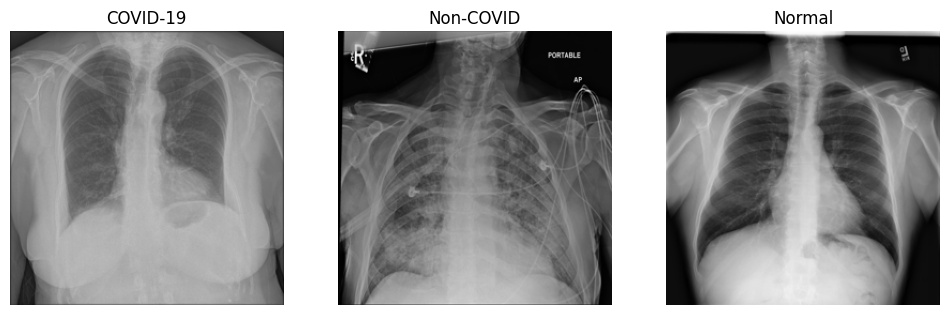

In [385]:
# Function to display images with labels
def display_images(images, labels):
    plt.figure(figsize=(12, 4))
    for i in range(len(images)):
        plt.subplot(1, 3, i + 1)
        plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Display the images with their labels
display_images(all_samples, labels)

In [386]:
def load_images_from_folder(folder, target):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if img_path.endswith('.png') or img_path.endswith('.jpg'):
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                labels.append(target)
    return images, labels

In [387]:
# Load images from each category
covid_images, covid_labels = load_images_from_folder(covid_images_path, 'COVID-19')
non_covid_images, non_covid_labels = load_images_from_folder(non_covid_images_path, 'Non-COVID')
normal_images, normal_labels = load_images_from_folder(normal_images_path, 'Normal')

In [388]:
# Combine all images and labels
all_images = np.r_[covid_images, non_covid_images,normal_images]
all_labels = np.r_[covid_labels, non_covid_labels,normal_labels]

In [389]:
# Resize images
def resize_images(images, size=(200, 200)):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, size)
        resized_images.append(resized_img)
    return resized_images
resized_images = resize_images(all_images)

In [390]:
# Convert labels to numerical format
label_mapping = {'COVID-19': 0, 'Non-COVID': 1, 'Normal': 2}
numeric_labels = [label_mapping[label] for label in all_labels]

In [391]:
# Convert to NumPy arrays
X = np.array(resized_images)
y = np.array(numeric_labels)

In [392]:
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (5417, 200, 200, 3)
Shape of y: (5417,)


This indicates that we have a dataset of 5417 images, each of size 200*200 with 3 color channels RGB, and each image has a corresponding label.

# Image Augmentation

In [393]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [394]:
# Image data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [395]:
# Example of augmenting images
X_augmented = []
y_augmented = []

In [396]:
for img, label in zip(X_train, y_train):
    img = img.reshape((1,) + img.shape)  # Reshape image for data generator
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        X_augmented.append(batch[0])
        y_augmented.append(label)
        i += 1
        if i >= 5:  # Number of augmented images per original image
            break

In [397]:
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

In [398]:
print(f"Shape of X_augmented: {X_augmented.shape}")
print(f"Shape of y_augmented: {y_augmented.shape}")

Shape of X_augmented: (21665, 200, 200, 3)
Shape of y_augmented: (21665,)


# Preprocessing: Intensity Thresholds, Histogram Equalization, and Gaussian Blur

In [399]:
def preprocess_images(images):
    processed_images = []
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Convert the grayscale image to uint8 type
        gray_img = np.uint8(gray_img)
        # Histogram equalization
        equalized_img = cv2.equalizeHist(gray_img)
        # Gaussian Blur
        blurred_img = cv2.GaussianBlur(equalized_img, (5, 5), 0)
        processed_images.append(blurred_img)
    return np.array(processed_images)

unint8 type:- In the context of image processing, it represents an 8-bit unsigned integer data type, which means it can hold integer values ranging from 0 to 255.

Histogram equalization enhances the contrast of the image by spreading out the intensity values.

Gaussian blur smoothens the image by averaging pixel values in the neighborhood, which helps in reducing noise and detail.

In [400]:
X_processed = preprocess_images(X_augmented)
print(f"Shape of X_processed: {X_processed.shape}")

Shape of X_processed: (21665, 200, 200)


# Model Implementation - CNN

In [401]:
y_one_hot = to_categorical(y_augmented, num_classes=3)

In [402]:
# Split the data into training and testing sets


In [403]:
def create_cnn_model():
    model = Sequential([
        Conv2D(32, 3, input_shape=(200, 200, 1), activation='relu'),
        MaxPooling2D(),
        Conv2D(16, 3, activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(16, 3, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')  # Changed to 3 classes
    ])
    return model

In [404]:
# Reshape data to match the input shape of the CNN
#X_train = X_processed.reshape(X_processed.shape[0], 200, 200, 1)
#X_test = X_test.reshape(X_test.shape[0], 200, 200, 1)
# Convert labels to categorical one-hot encoding
#y_train = to_categorical(y_train, num_classes=3)
#y_test = to_categorical(y_test, num_classes=3)


In [405]:
cnn_model = create_cnn_model()
cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [406]:
cnn_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 198, 198, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 97, 97, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 48, 48, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 46, 46, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 8464)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     1,083,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,091,171 (4.16 MB)

 Trainable params: 1,091,171 (4.16 MB)

 Non-trainable params: 0 (0.00 B)

This is the total number of parameters in the model, which includes both trainable and non-trainable parameters. However as non-trainable parameters is 0, all of the parameters are trainable.

In [407]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [408]:
cnn_history = cnn_model.fit(X_processed, y_one_hot, epochs=10, batch_size=32, validation_split=0.20,callbacks=early_stopping)


Epoch 1/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 80s 146ms/step - accuracy: 0.3644 - loss: 9.8273 - val_accuracy: 0.3891 - val_loss: 1.0909
Epoch 2/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 78s 144ms/step - accuracy: 0.4458 - loss: 1.0390 - val_accuracy: 0.5091 - val_loss: 0.9949
Epoch 3/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 78s 143ms/step - accuracy: 0.4801 - loss: 0.9967 - val_accuracy: 0.5333 - val_loss: 0.9666
Epoch 4/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 79s 147ms/step - accuracy: 0.5155 - loss: 0.9630 - val_accuracy: 0.5585 - val_loss: 0.9501
Epoch 5/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 78s 143ms/step - accuracy: 0.5311 - loss: 0.9379 - val_accuracy: 0.5306 - val_loss: 0.9692
Epoch 6/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 78s 144ms/step - accuracy: 0.5443 - loss: 0.9233 - val_accuracy: 0.5800 - val_loss: 0.9045
Epoch 7/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 78s 143ms/step - accuracy: 0.5541 - loss: 0.9026 - val_accuracy: 0.5737 - val_loss: 0.8750
Epoch 8/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 78s 144ms/step - accuracy: 0.5741 - loss: 0

In [409]:
# Evaluate the model
cnn_train_loss, cnn_train_accuracy = cnn_model.evaluate(X_processed, y_one_hot)
print(f"CNN Train accuracy: {cnn_train_accuracy * 100:.2f}%")

678/678 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.6675 - loss: 0.7762
CNN Train accuracy: 65.73%


In [410]:
X_testaugmented = []
y_testaugmented=[]

In [411]:
for img, label in zip(X_test, y_test):
    img = img.reshape((1,) + img.shape)  # Reshape image for data generator
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        X_testaugmented.append(batch[0])
        y_testaugmented.append(label)
        i += 1
        if i >= 5:  # Number of augmented images per original image
            break

In [412]:
X_testaugmented = np.array(X_testaugmented)
y_testaugmented = np.array(y_testaugmented)

In [413]:
X_testaugmented.shape
y_testaugmented.shape

(5420,)

In [414]:
y_test = to_categorical(y_testaugmented, num_classes=3)

In [415]:
X_testprocessed = preprocess_images(X_testaugmented)


In [416]:
X_testprocessed.shape

(5420, 200, 200)

In [417]:
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_testprocessed, y_test)
print(f"CNN Test accuracy: {cnn_test_accuracy * 100:.2f}%")

170/170 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5795 - loss: 0.8983
CNN Test accuracy: 58.51%


This CNN model had an test accuracy of 61.67%.

In [418]:
# Generate predictions and evaluate using confusion matrix and AUC
y_pred_cnn = cnn_model.predict(X_testprocessed)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

170/170 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step


In [419]:
cnn_conf_matrix = confusion_matrix(y_test_classes, y_pred_cnn_classes)
cnn_auc = roc_auc_score(y_test, y_pred_cnn, multi_class='ovr')

In [420]:
print(f"CNN Confusion Matrix:\n{cnn_conf_matrix}")

CNN Confusion Matrix:
[[1398  200  432]
 [ 549  859  232]
 [ 650  186  914]]


# Plotting Confusion matrix


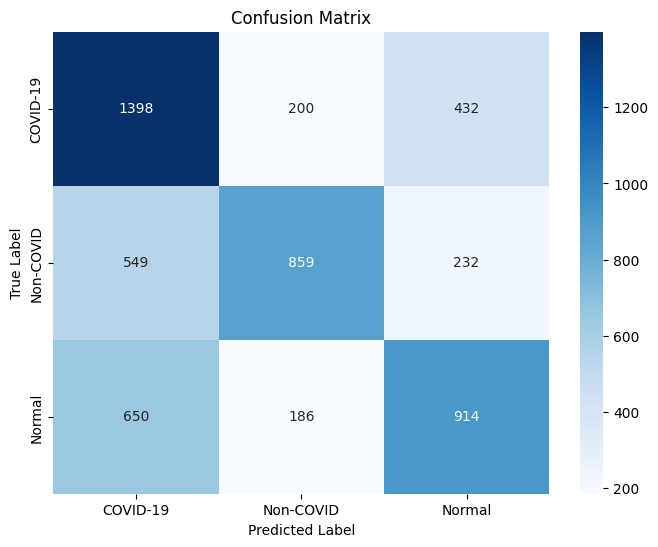

In [421]:
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['COVID-19', 'Non-COVID', 'Normal'], yticklabels=['COVID-19', 'Non-COVID', 'Normal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

This confusion matrix helps to understand how well the model is performing for each class, showing the distribution of correct and incorrect predictions. 

In [422]:
print(f"CNN AUC: {cnn_auc:.2f}")

CNN AUC: 0.77


AUC = 0.80 means there is a 80% chance that the model will correctly distinguish between positive and negative classes.

# Plotting ROC Curve

In [423]:
# Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_cnn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

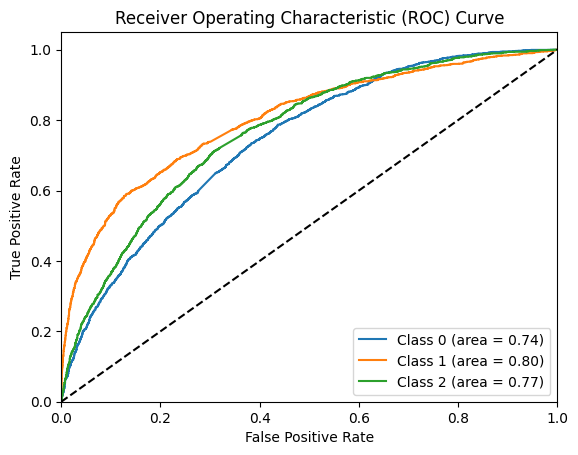

In [424]:
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

By plotting ROC curves for each class, we can see how well the model performs for each class individually.

# Principal Component Analysis

In [425]:
# Perform PCA for feature set comparison
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_processed.reshape(X_processed.shape[0], -1))

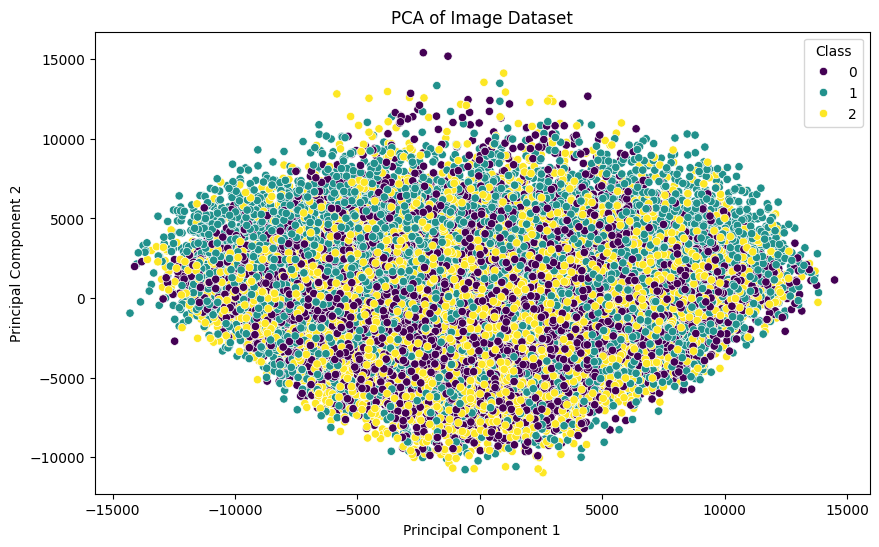

In [426]:
# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_augmented, palette='viridis', legend='full')
plt.title('PCA of Image Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class')
plt.show()

In [428]:
cnn_model.save('/Users/seshasaimeka/Downloads/dnn_covid_model.h5')